## Weight and Biases 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BoostcampAITech/lecture-note-python-basics-for-ai/blob/main/codes/pytorch/07_torch-study/visualization/wandb.ipynb)

In [1]:
import wandb
wandb.init(project="Myproject", entity='oochaewonoo')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/lee/.netrc


In [2]:
import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
import torch.optim as optim
import os


import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## print out the pytorch version used (1.31 at the time of this tutorial)
print(torch.__version__)

1.13.1


In [4]:
DATA_PATH = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"

In [5]:
import urllib
import os
import shutil
from zipfile import ZipFile

urllib.request .urlretrieve(DATA_PATH, "hymenoptera_data.zip")

with ZipFile("hymenoptera_data.zip", 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()


In [6]:
## configure root folder on your gdrive
data_dir = "./hymenoptera_data"

## custom transformer to flatten the image tensors
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        result = torch.reshape(img, self.new_size)
        return result

## transformations used to standardize and normalize the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

## load the correspoding folders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

## load the entire dataset; we are not using minibatches here
train_dataset = torch.utils.data.DataLoader(image_datasets['train'],
                                            batch_size=len(image_datasets['train']),
                                            shuffle=True)

In [7]:
class MyCNNModel(nn.Module):
    def __init__(self):
        super(MyCNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3 * 3 * 64, 1000)
        self.fc2 = nn.Linear(1000, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [8]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.01

In [9]:

model = MyCNNModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [10]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [11]:
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

config={"epochs": EPOCHS, "batch_size": BATCH_SIZE, "learning_rate" : LEARNING_RATE}

만약 실험을 바꾸고 싶다면 EPOCHS, BATCH_SIZE, LEARNING_RATE 을 바꿔 진행하면 된다!

In [12]:
wandb.init(project="MyProject", config=config)

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_dataset:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).type(torch.cuda.FloatTensor)
        optimizer.zero_grad()        
        y_pred = model(X_batch)
               
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        
    train_loss = epoch_loss/len(train_dataset)
    train_acc = epoch_acc/len(train_dataset)
    print(f'Epoch {e+0:03}: | Loss: {train_loss:.5f} | Acc: {train_acc:.3f}')
    wandb.log({'accuracy': train_acc, 'loss': train_loss})


RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

wandb.log({'accuracy': train_acc, 'loss': train_loss}) : acc과 loss가 추가되도록 함

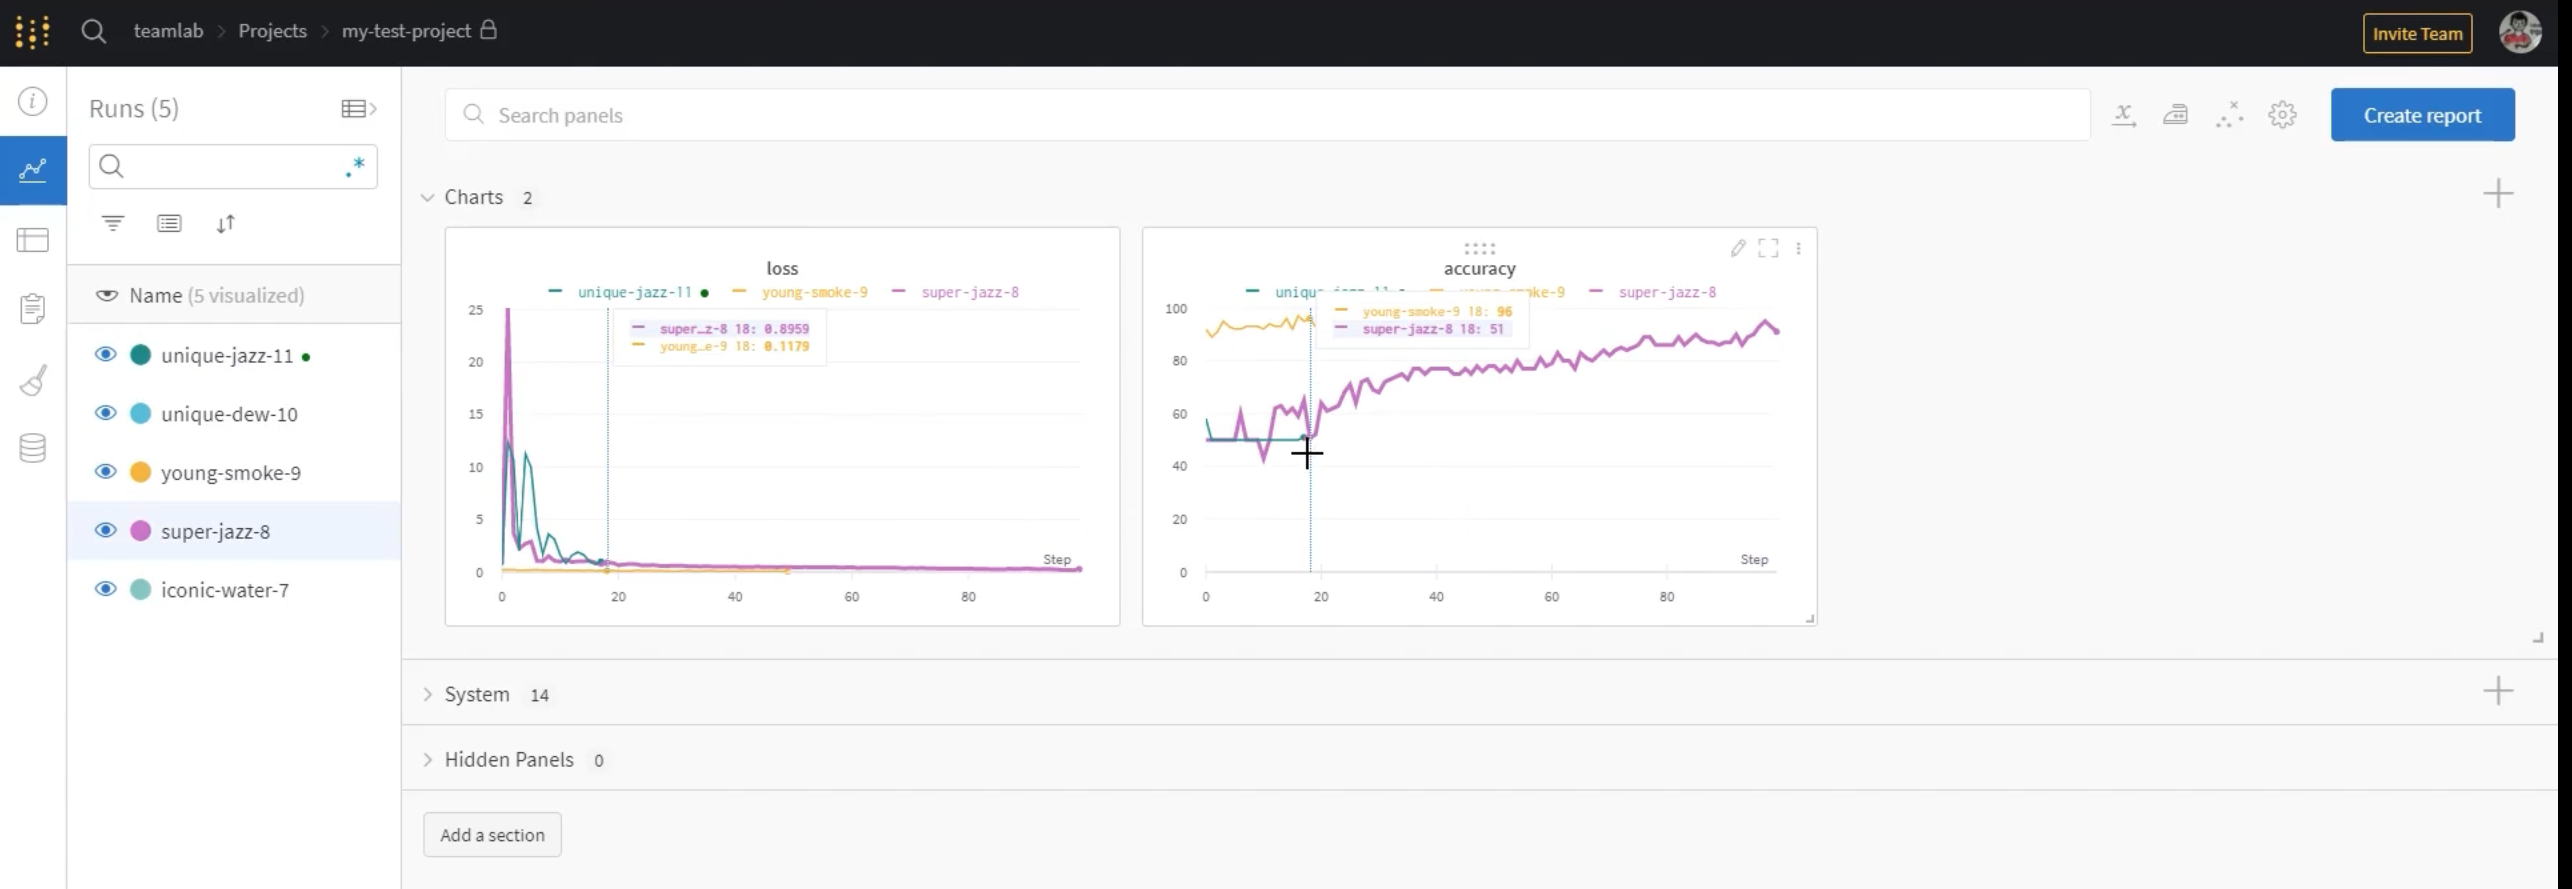
- 다음과 같이 확인할 수 있도록 함

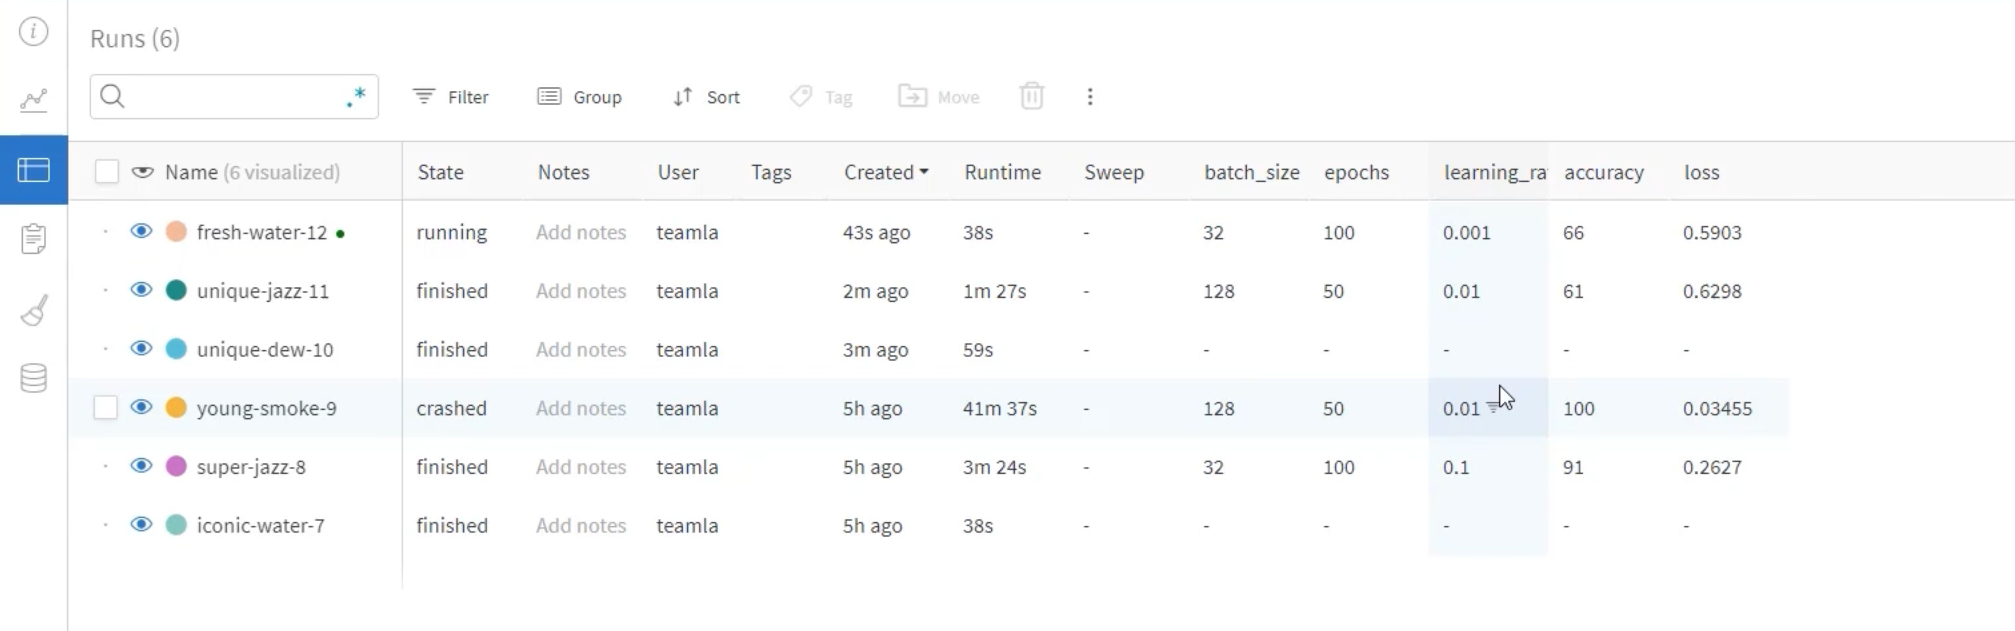

진행했던 실험들을 관리하고 볼 수 있다

따로, tutorial가 존재한다!